In [1]:
import pickle
import numpy as np
import json
from sklearn.metrics import precision_recall_curve, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import fasttext

In [2]:
# helper functions
def read_pickle(filepath):
    with open(filepath,"rb") as f:
        output = pickle.load(f)
    return output

def get_row_count(file_path):
    count = 0
    with open(file_path, 'r') as f:
        for line in f:
            count += 1
    return count

def list_to_dict(cur_list):
    cur_dict = dict()
    for i, label in enumerate(cur_list):
        cur_dict[label] = i
    return cur_dict

def remove_label(line):
    tokens = line.rstrip().split(" ")
    for i, token in enumerate(tokens):
        if "__label__" not in token:
            break
    return " ".join(tokens[i:])

In [3]:
def extract_labels(subgroup_labels, level_number):
    labels = set()
    for subgroup_label in subgroup_labels:
        subgroup_label_splits = subgroup_label.split("--")
        labels.add("--".join(subgroup_label_splits[:level_number]).replace(" ", "_"))
    return list(labels)

In [4]:
# given the path of the true label file (Tencent format)
# return a 2D numpy array of size (# of instance, # of labels)
# where each row is an n-hot vector indicating true label(s)
def get_truth_array(truth_path, label_to_id_map):
    
    truth_array = np.zeros((get_row_count(truth_path), len(label_to_id_map)), dtype = int)
    sample_label = list(label_to_id_map.keys())[0]
    level_number = sum(1 for i in range(len(sample_label)) if sample_label.startswith("--", i)) + 1
    
    with open(truth_path, 'r') as truth_file:  
        for i, truth in enumerate(truth_file):
            json_dict = json.loads(truth)
            if "doc_label" in json_dict:
                true_labels = json_dict["doc_label"]
            else:
                true_labels = extract_labels(json_dict["all_labels"], level_number)
                
            for true_label in true_labels:
                true_id = label_to_id_map[true_label]
                truth_array[i][true_id] = 1
    return truth_array

In [5]:
# get probability matrix of size (# of instance, # of labels) from Tencent format
def get_predicted_probs_from_json(probs_path):
    probs = []
    with open(probs_path, 'r') as probs_file:  
        for prob in probs_file:
            probs.append(json.loads(prob))
    return np.array(probs)

In [6]:
# get probability matrix of size (# of instance, # of labels) from FastText format
def get_predicted_probs_from_FASTTEXT(model_path, valid_path):
    model = fasttext.load_model(model_path)
    row_count = get_row_count(valid_path)
    label_to_id_map = list_to_dict([label[9:] for label in model.get_labels()])
    
    probs_matrix = np.zeros((row_count, len(label_to_id_map)))
    
    with open(valid_path, 'r') as file:  
        for i, line in enumerate(file):
            line = remove_label(line)
            labels, probs = model.predict(line, k=-1)
            for label, prob in zip(labels, probs):
                label_id = label_to_id_map[label[9:]]
                probs_matrix[i][label_id] = prob
        
    return label_to_id_map, probs_matrix

In [25]:
# get probability matrix of size (# of instance, # of labels) from FastText format
# used for other text fields ('title’, ‘abstraction’, ‘claims’, ‘description’)
def get_predicted_probs_from_FASTTEXT_other_fields(model_path, valid_path, text_fields):
    model = fasttext.load_model(model_path)
    row_count = get_row_count(valid_path)
    label_to_id_map = list_to_dict([label[9:] for label in model.get_labels()])
    
    probs_matrix = np.zeros((row_count, len(label_to_id_map)))
    
    with open(valid_path, 'r') as file:  
        for i, line in enumerate(file):
            
            data = json.loads(line)
            tokens = []
            for text_field in text_fields:
                tokens += data[text_field]
            labels, probs = model.predict(" ".join(tokens), k=-1)
            for label, prob in zip(labels, probs):
                label_id = label_to_id_map[label[9:]]
                probs_matrix[i][label_id] = prob
        
    return label_to_id_map, probs_matrix

In [8]:
# get probability matrix of size (# of instance, # of labels) from HFT-CNN format
def convert_at_to_dash(at_string):
    labels = at_string.split("@")
    prefix = ""
    long_labels = []
    for label in labels:
        long_label = prefix + label
        long_labels.append(long_label)
        prefix = long_label
    return "--".join(long_labels)

def get_predicted_probs_from_json_with_header(probs_path):
    probs = []
    with open(probs_path, 'r') as probs_file:  
        for i, prob in enumerate(probs_file):
            if i == 0:
                label_list = prob.rstrip().split(",")
                if "@" in label_list[0]:
                    label_list = [convert_at_to_dash(at_string) for at_string in label_list]
            else:
                json_string = "[{}]".format(prob.rstrip())
                probs.append(json.loads(json_string))
    return list_to_dict(label_list), np.array(probs)

In [9]:
# convert probability matrix into rank matrix of the same size
def prob_to_rank(probs):
    label_count = probs.shape[1]
    ranks = pd.DataFrame(probs).rank(axis=1, method='max')
    return np.array(ranks)

In [10]:
# calculate AUC given precisions and recalls
def get_auc(precisions, recalls):
    auc = 0
    for i in range(len(precisions) - 1):
        auc += (precisions[i] + precisions[i+1]) * (recalls[i] - recalls[i+1]) / 2
    return auc

In [11]:
# for each row in the prob matrix, get the number of probabilities larger than the threshold
def get_average_n(probs, threshold):
    return (probs > threshold).sum(axis=1).mean()

# get nearest threshold given n
def find_flexible_n_threshold(flexible_ns, n):
    for i in range(len(flexible_ns)):
        if flexible_ns[i] < n:
            return THRESHOLDS[i-1]
    return -1

# get precision and recall given a threshold
def get_precision_recall(truth_array, probs, threshold):
    
    truth_array_flat = truth_array.ravel()
    probs_flat = probs.ravel() >= threshold
    
    precision = precision_score(truth_array_flat, probs_flat)
    recall = recall_score(truth_array_flat, probs_flat)
    return precision, recall

In [12]:
# generate pr curve
def get_pr_curve(truth_array, probs, title_prefix):
    
    prob_precisions, prob_recalls, prob_thresholds = precision_recall_curve(truth_array.ravel(), probs.ravel())
    prob_auc = get_auc(prob_precisions, prob_recalls)
    
    ranks = prob_to_rank(probs)
    rank_precisions, rank_recalls, rank_thresholds = precision_recall_curve(truth_array.ravel(), ranks.ravel())
    rank_auc = get_auc(rank_precisions, rank_recalls)
    
    plt.figure()
    plt.step(prob_recalls, prob_precisions, where='post', label='prob')
    plt.step(rank_recalls, rank_precisions, where='post', label='rank')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend(loc='upper right')
    plt.title('{0}, AUC: prob {1:0.2f} rank {2:0.2f}'
              .format(title_prefix, prob_auc, rank_auc))
    
    plt.show()
    
    
    flexible_ns = [get_average_n(probs, threshold) for threshold in THRESHOLDS]
    prob_result = prob_precisions, prob_recalls, prob_thresholds, prob_auc, flexible_ns
    rank_result = rank_precisions, rank_recalls, rank_thresholds, rank_auc
    
    prob_threshold_at_5 = find_flexible_n_threshold(flexible_ns, 5)
    
    print("precision@1: {}".format(rank_precisions[-2]))
    print("recall@1: {}".format(rank_recalls[-2]))
    print("precision@5: {}".format(rank_precisions[-6]))
    print("recall@5: {}".format(rank_recalls[-6]))
    
    precision, recall = get_precision_recall(truth_array, probs, prob_threshold_at_5)
    
    print("if using probability threshold at {}".format(prob_threshold_at_5))
    print("average n: {}".format(get_average_n(probs, prob_threshold_at_5)))
    print("precision: {}".format(precision))
    print("recall: {}".format(recall))
    
    return prob_result, rank_result

In [13]:
# generate truth matrix and prob matrix for Tencent format
def get_truth_probs_map_tencent(truth_path, model_folder_name):
    probs_path = "{}/{}/probs.txt".format(TENCENT_FOLDER_PATH, model_folder_name)
    label_to_id_maps_path = "{}/{}/label_to_id_maps.pkl".format(TENCENT_FOLDER_PATH, model_folder_name)
    
    label_to_id_map = read_pickle(label_to_id_maps_path)[0]
    truth_array = get_truth_array(truth_path, label_to_id_map)
    probs = get_predicted_probs_from_json(probs_path)
    
    return label_to_id_map, truth_array, probs


# generate truth matrix and prob matrix for FastText format
def get_truth_probs_map_fasttext(truth_path, model_folder_name):

    model_path = "{}/{}/fasttext_model.bin".format(FASTTEXT_FOLDER_PATH, model_folder_name)
    label_to_id_map, probs = get_predicted_probs_from_FASTTEXT(model_path, FASTTEXT_TEST_PATH)
    truth_array = get_truth_array(truth_path, label_to_id_map)
    
    return label_to_id_map, truth_array, probs


# generate truth matrix and prob matrix for HFT-CNN format
def get_truth_probs_map_hftcnn(truth_path, probs_path):
    
    label_to_id_map, probs = get_predicted_probs_from_json_with_header(probs_path)
    truth_array = get_truth_array(truth_path, label_to_id_map)

    return label_to_id_map, truth_array, probs

In [14]:
# given label to id map 1 and its corresponding prob matrix
# given another label to id map 2, shuffle the prob matrix to match map 2
def sync_probs(label_to_id_map_1, label_to_id_map_2, probs_1):
    length = len(label_to_id_map_1)
    indices = np.zeros(length, dtype = 'int')
    for label in label_to_id_map_1:
        indices[label_to_id_map_2[label]] = label_to_id_map_1[label]
    probs_2 = np.copy(probs_1)[:, indices]
    return probs_2

# generate truth matrix and prob matrix for ensemble models
# model_types: list of model types (model type can be either "tencent" or "fasttext")
# folders: list of model folder names
# weights: list of weights assigned to each model
def get_truth_probs_map_ensemble(model_types, folders, weights):
    
    print(model_types)
    print(folders)
    print(weights)
    
    probs_list = []
    label_to_id_map_list = []
    
    for i in range(len(folders)):
        if model_types[i] == "tencent":
            label_to_id_map, truth_array, probs = get_truth_probs_map_tencent(TRUTH_PATH, folders[i])
        elif model_types[i] == "fasttext":
            label_to_id_map, truth_array, probs = get_truth_probs_map_fasttext(TRUTH_PATH, folders[i])
        else:
            print("wrong model type!")
        
        if i == 0:
            final_truth_array = np.copy(truth_array)
            
        probs_list.append(probs)
        label_to_id_map_list.append(label_to_id_map)
        
    final_probs = np.zeros(probs_list[0].shape)
    for i in range(len(folders)):
        if i == 0:
            final_probs += weights[i] * probs_list[i]
        else: 
            final_probs += weights[i] * sync_probs(label_to_id_map_list[i], label_to_id_map_list[0], probs_list[i])
        
    return label_to_id_map_list[0], final_truth_array, final_probs

In [15]:
# global variables
LEVEL_NAMES = ["section", "class", "subclass", "main group", "subgroup"]
TRUTH_PATH = "/pylon5/sez3a3p/yyn1228/data/all_summary_nonstop/test_small.json"
FASTTEXT_TEST_PATH = "/pylon5/sez3a3p/yyn1228/data/all_summary_fasttext/test_small.json"
TENCENT_FOLDER_PATH = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/NeuralClassifier/output"
FASTTEXT_FOLDER_PATH = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/FastText"
THRESHOLDS = np.arange(0.0, 1.0, 0.005)

## Tencent Model

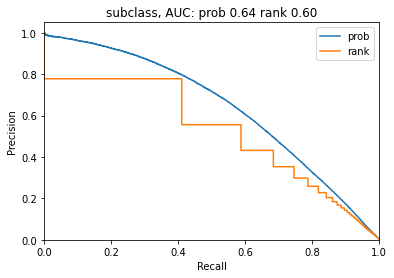

precision@1: 0.7776333333333333
recall@1: 0.41122137808252984
precision@5: 0.2980433333333333
recall@5: 0.7880435740600378
if using probability threshold at 0.185
average n: 5.0695
precision: 0.3042640628595851
recall: 0.8156739701397825


In [21]:
# 3rd model: tencent CNN (CNN_summary_only_all)
model_folder_name = "CNN_summary_only_all"
label_to_id_map, truth_array, probs = get_truth_probs_map_tencent(TRUTH_PATH, model_folder_name)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

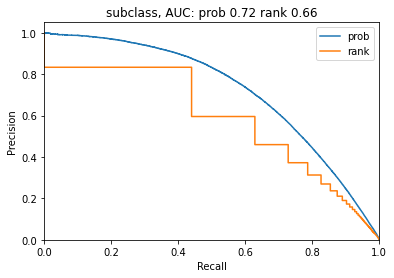

precision@1: 0.8331666666666667
recall@1: 0.44058803828594595
precision@5: 0.3128633333333333
recall@5: 0.827228499409494
if using probability threshold at 0.17500000000000002
average n: 5.104733333333333
precision: 0.32069255984641704
recall: 0.8656907158343763


In [15]:
# 3rd model: tencent RCNN (RCNN_summary_all）
model_folder_name = "RCNN_summary_all"
label_to_id_map, truth_array, probs = get_truth_probs_map_tencent(TRUTH_PATH, model_folder_name)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

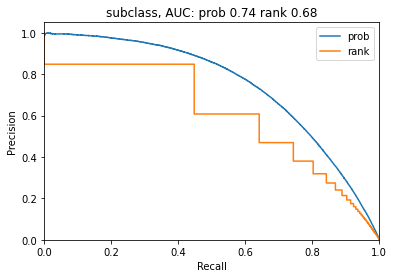

precision@1: 0.8478833333333333
recall@1: 0.44837037951032066
precision@5: 0.31889
recall@5: 0.8431633498440007
if using probability threshold at 0.165
average n: 5.139233333333333
precision: 0.3254052160828139
recall: 0.8843489450212406


In [44]:
# 3rd model: tencent RNN (RNN_summary_all_2）
model_folder_name = "RNN_summary_all_2"
label_to_id_map, truth_array, probs = get_truth_probs_map_tencent(TRUTH_PATH, model_folder_name)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

## FastText Model

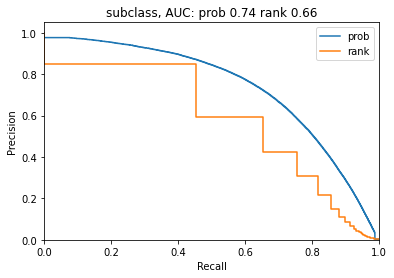

precision@1: 0.8505302165533443
recall@1: 0.45312086866087325
precision@5: 0.21571426351460848
recall@5: 0.8564100756200314
if using probability threshold at 0.025
average n: 5.3913166666666665
precision: 0.3126632640758751
recall: 0.891399763797571


In [41]:
model_folder_name = "summary_all_subclass"
label_to_id_map, truth_array, probs = get_truth_probs_map_fasttext(TRUTH_PATH, model_folder_name)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

## HFT-CNN Model

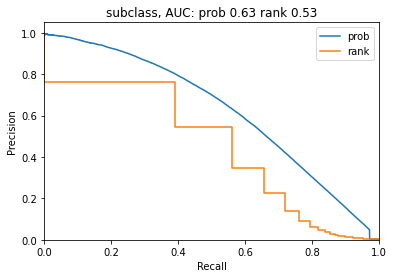

precision@1: 0.7634030497458545
recall@1: 0.390443476556174
precision@5: 0.13798291084105105
recall@5: 0.7614363764990667
if using probability threshold at 0.055
average n: 5.006783333333333
precision: 0.31051745142027865
recall: 0.7951552551503115


In [38]:
# 2nd model HFT-CNN (summary all data)
hftcnn_truth_path = "/pylon5/sez3a3p/yyn1228/data/summary_only_nonstop/test.json"
probs_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/HFT-CNN/CNN/RESULT/probability_3rd.csv"
label_to_id_map, truth_array, probs = get_truth_probs_map_hftcnn(hftcnn_truth_path, probs_path)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

## Ensemble Models

['tencent', 'tencent']
['CNN_summary_only_all', 'RCNN_summary_all']
[0.5, 0.5]


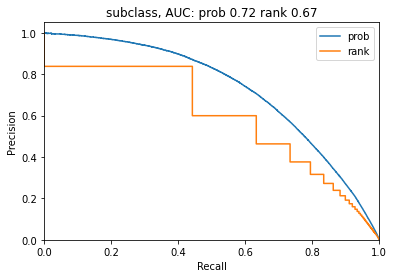

precision@1: 0.8375666666666667
recall@1: 0.442914808482135
precision@5: 0.31589
recall@5: 0.8352311787206289
if using probability threshold at 0.17
average n: 5.130733333333334
precision: 0.32243928743129635
recall: 0.8748391531966649


In [73]:
# 0.5 * CNN + 0.5 * RCNN
label_to_id_map, truth_array, probs = get_truth_probs_map_ensemble(
    ["tencent", "tencent"], 
    ["CNN_summary_only_all", "RCNN_summary_all"], 
    [0.5, 0.5]
)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

['tencent', 'tencent']
['CNN_summary_only_all', 'RNN_summary_all_2']
[0.5, 0.5]


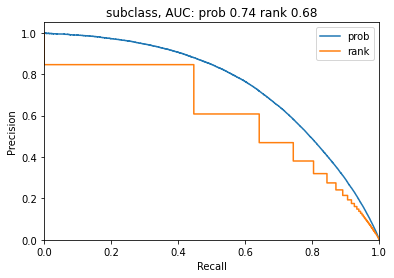

precision@1: 0.8457833333333333
recall@1: 0.4472598755530486
precision@5: 0.31956666666666667
recall@5: 0.8449524951084945
if using probability threshold at 0.17
average n: 5.015716666666667
precision: 0.3324117856205328
recall: 0.8816784474097055


In [74]:
# 0.5 * CNN + 0.5 * RNN
label_to_id_map, truth_array, probs = get_truth_probs_map_ensemble(
    ["tencent", "tencent"], 
    ["CNN_summary_only_all", "RNN_summary_all_2"], 
    [0.5, 0.5]
)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

['tencent', 'tencent', 'tencent']
['CNN_summary_only_all', 'RNN_summary_all_2', 'RCNN_summary_all']
[0.333, 0.333, 0.333]


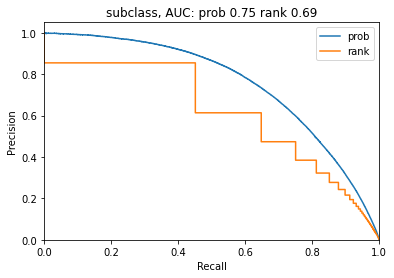

precision@1: 0.8544166666666667
recall@1: 0.45182528071072253
precision@5: 0.32226666666666665
recall@5: 0.852091449119529
if using probability threshold at 0.165
average n: 5.086766666666667
precision: 0.3321166687417679
recall: 0.8933739930549435


In [75]:
# 0.333 * CNN + 0.333 * RNN + 0.333 * RCNN
label_to_id_map, truth_array, probs = get_truth_probs_map_ensemble(
    ["tencent", "tencent", "tencent"], 
    ["CNN_summary_only_all", "RNN_summary_all_2", "RCNN_summary_all"], 
    [0.333, 0.333, 0.333]
)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

['tencent', 'tencent', 'tencent', 'fasttext']
['CNN_summary_only_all', 'RNN_summary_all_2', 'RCNN_summary_all', 'summary_all_subclass']
[0.25, 0.25, 0.25, 0.25]


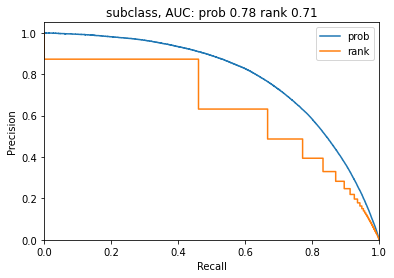

precision@1: 0.87225
recall@1: 0.46125575082406445
precision@5: 0.32943
recall@5: 0.8710317110574466
if using probability threshold at 0.135
average n: 5.0323166666666665
precision: 0.34162860710275916
recall: 0.9091237594965715


In [77]:
# 0.25 * CNN + 0.25 * RNN + 0.25 * RCNN + 0.25 * FastText
label_to_id_map, truth_array, probs = get_truth_probs_map_ensemble(
    ["tencent", "tencent", "tencent", "fasttext"], 
    ["CNN_summary_only_all", "RNN_summary_all_2", "RCNN_summary_all", "summary_all_subclass"], 
    [0.25, 0.25, 0.25, 0.25]
)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

['tencent', 'tencent', 'tencent', 'fasttext']
['CNN_summary_only_all', 'RNN_summary_all_2', 'RCNN_summary_all', 'summary_all_subclass']
[0.2, 0.2, 0.2, 0.4]


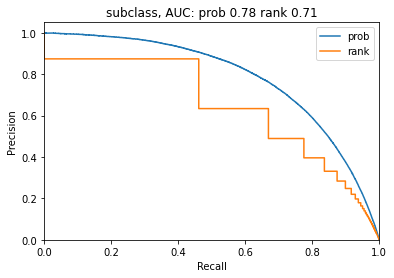

precision@1: 0.8737
recall@1: 0.46202252736599037
precision@5: 0.3310133333333333
recall@5: 0.8752181347058927
if using probability threshold at 0.115
average n: 5.00735
precision: 0.3444236971651672
recall: 0.912014595194867


In [79]:
# 0.2 * CNN + 0.2 * RNN + 0.2 * RCNN + 0.4 * FastText
label_to_id_map, truth_array, probs = get_truth_probs_map_ensemble(
    ["tencent", "tencent", "tencent", "fasttext"], 
    ["CNN_summary_only_all", "RNN_summary_all_2", "RCNN_summary_all", "summary_all_subclass"], 
    [0.2, 0.2, 0.2, 0.4]
)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

['tencent', 'tencent', 'tencent', 'fasttext']
['CNN_summary_only_all', 'RNN_summary_all_2', 'RCNN_summary_all', 'summary_all_subclass']
[0.1, 0.1, 0.1, 0.7]


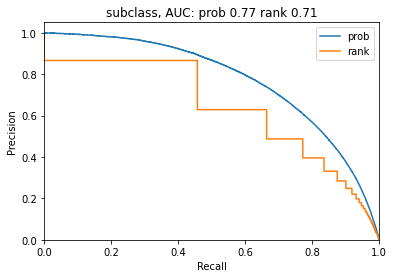

precision@1: 0.8658833333333333
recall@1: 0.45788898485836665
precision@5: 0.33114333333333335
recall@5: 0.8755618621212389
if using probability threshold at 0.07
average n: 5.085233333333333
precision: 0.340485851190047
recall: 0.9156105127707955


In [78]:
# 0.1 * CNN + 0.1 * RNN + 0.1 * RCNN + 0.7 * FastText
label_to_id_map, truth_array, probs = get_truth_probs_map_ensemble(
    ["tencent", "tencent", "tencent", "fasttext"], 
    ["CNN_summary_only_all", "RNN_summary_all_2", "RCNN_summary_all", "summary_all_subclass"], 
    [0.1, 0.1, 0.1, 0.7]
)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

## Other Levels

In [28]:
TRUTH_PATH_2 = "/pylon5/sez3a3p/yyn1228/data/all_data_small/test_small.json"

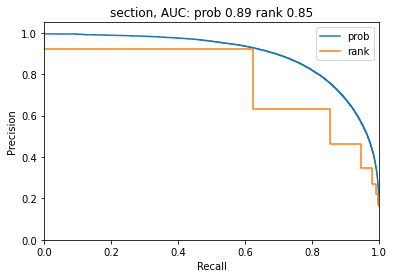

precision@1: 0.921493370551291
recall@1: 0.6225627209968008
precision@5: 0.2708942201832049
recall@5: 0.9915698490205983
if using probability threshold at 0.0
average n: 9.0
precision: 0.16497222222222221
recall: 1.0


In [29]:
# SECTION LEVEL
model_folder_name = "summary_all_section"
label_to_id_map, truth_array, probs = get_truth_probs_map_fasttext(TRUTH_PATH_2, model_folder_name)
prob_result, rank_result = get_pr_curve(truth_array, probs, "section")

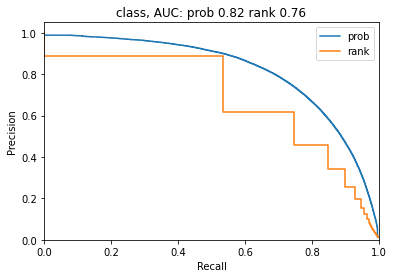

precision@1: 0.8858603632017529
recall@1: 0.5347991221301371
precision@5: 0.25721507327440307
recall@5: 0.9290488741018369
if using probability threshold at 0.015
average n: 5.557316666666667
precision: 0.28598634232948156
recall: 0.9556254822772505


In [31]:
# CLASS LEVEL
model_folder_name = "summary_all_class"
label_to_id_map, truth_array, probs = get_truth_probs_map_fasttext(TRUTH_PATH_2, model_folder_name)
prob_result, rank_result = get_pr_curve(truth_array, probs, "class")

In [44]:
# GROUP LEVEL
test_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_fasttext_group/test.json"
model_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/FastText/summary_all_group/fasttext_model.bin"
model = fasttext.load_model(model_path)

In [45]:
k = 1
N, p, r = model.test(test_path, k=k) 
print("N\t" + str(N))
print("P@{}\t{:.3f}".format(k, p))
print("R@{}\t{:.3f}".format(k, r))

N	478562
P@1	0.651
R@1	0.220


In [46]:
k = 10
N, p, r = model.test(test_path, k=k)
print("N\t" + str(N))
print("P@{}\t{:.3f}".format(k, p))
print("R@{}\t{:.3f}".format(k, r))

N	478562
P@10	0.195
R@10	0.661


In [47]:
k = 100
N, p, r = model.test(test_path, k=k)
print("N\t" + str(N))
print("P@{}\t{:.3f}".format(k, p))
print("R@{}\t{:.3f}".format(k, r))

N	478562
P@100	0.027
R@100	0.912


In [48]:
threshold = 0.1
N, p, r = model.test(test_path, k=-1, threshold=threshold)
print("N\t" + str(N))
print("P@threshold {}\t{:.3f}".format(threshold, p))
print("R@threshold {}\t{:.3f}".format(threshold, r))

N	478562
P@threshold 0.1	0.586
R@threshold 0.1	0.331


In [49]:
threshold = 0.5
N, p, r = model.test(test_path, k=-1, threshold=threshold)
print("N\t" + str(N))
print("P@threshold {}\t{:.3f}".format(threshold, p))
print("R@threshold {}\t{:.3f}".format(threshold, r))

N	478562
P@threshold 0.5	0.903
R@threshold 0.5	0.054


In [50]:
# SUBGROUP LEVEL
test_path = "/pylon5/sez3a3p/yyn1228/data/all_summary_fasttext_subgroup/test.json"
model_path = "/pylon5/sez3a3p/yyn1228/Dorothy-Ymir/model/FastText/summary_all_subgroup/fasttext_model.bin"
model = fasttext.load_model(model_path)

In [3]:
k = 1
N, p, r = model.test(test_path, k=k) 
print("N\t" + str(N))
print("P@{}\t{:.3f}".format(k, p))
print("R@{}\t{:.3f}".format(k, r))

N	478502
P@1	0.284
R@1	0.054


In [4]:
k = 10
N, p, r = model.test(test_path, k=k)
print("N\t" + str(N))
print("P@{}\t{:.3f}".format(k, p))
print("R@{}\t{:.3f}".format(k, r))

N	478502
P@10	0.109
R@10	0.208


In [5]:
k = 100
N, p, r = model.test(test_path, k=k)
print("N\t" + str(N))
print("P@{}\t{:.3f}".format(k, p))
print("R@{}\t{:.3f}".format(k, r))

N	478502
P@100	0.025
R@100	0.468


In [51]:
k = 1000
N, p, r = model.test(test_path, k=k)
print("N\t" + str(N))
print("P@{}\t{:.3f}".format(k, p))
print("R@{}\t{:.3f}".format(k, r))

N	478502
P@1000	0.004
R@1000	0.750


In [52]:
threshold = 0.1
N, p, r = model.test(test_path, k=-1, threshold=threshold)
print("N\t" + str(N))
print("P@threshold {}\t{:.3f}".format(threshold, p))
print("R@threshold {}\t{:.3f}".format(threshold, r))

N	478502
P@threshold 0.1	0.527
R@threshold 0.1	0.018


In [53]:
threshold = 0.5
N, p, r = model.test(test_path, k=-1, threshold=threshold)
print("N\t" + str(N))
print("P@threshold {}\t{:.3f}".format(threshold, p))
print("R@threshold {}\t{:.3f}".format(threshold, r))

N	478502
P@threshold 0.5	0.851
R@threshold 0.5	0.001


## Other Text Fields

In [18]:
model_folder_name = "summary_all_subclass"
model_path = "{}/{}/fasttext_model.bin".format(FASTTEXT_FOLDER_PATH, model_folder_name)
test_path = "/pylon5/sez3a3p/yyn1228/data/all_data_small/test_small.json"

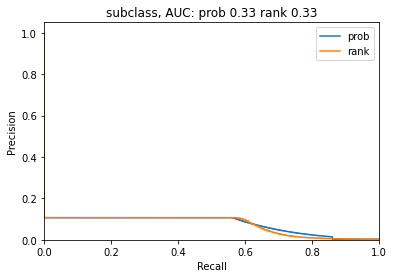

precision@1: 0.10711077235266084
recall@1: 0.5684898908885795
precision@5: 0.09765642294931652
recall@5: 0.6026334808129594
if using probability threshold at -1
average n: 665.0
precision: 0.002843659147869674
recall: 1.0


In [21]:
model_folder_name = "summary_all_subclass"
model_path = "{}/{}/fasttext_model.bin".format(FASTTEXT_FOLDER_PATH, model_folder_name)
test_path = "/pylon5/sez3a3p/yyn1228/data/all_data_small/test_small.json"
label_to_id_map, probs = get_predicted_probs_from_FASTTEXT_other_fields(model_path, test_path, ["title"])
truth_array = get_truth_array(TRUTH_PATH, label_to_id_map)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

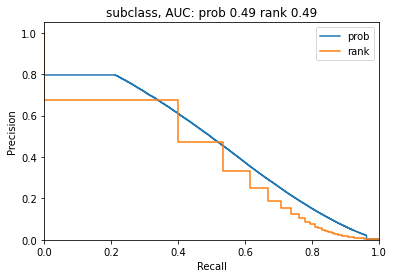

precision@1: 0.6746346168113362
recall@1: 0.40072447162926794
precision@5: 0.18957579472189154
recall@5: 0.7087747439671432
if using probability threshold at 0.32
average n: 5.01235
precision: 0.26260802484529877
recall: 0.6960656431228076


In [23]:
label_to_id_map, probs = get_predicted_probs_from_FASTTEXT_other_fields(model_path, test_path, ["abstraction"])
truth_array = get_truth_array(TRUTH_PATH, label_to_id_map)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

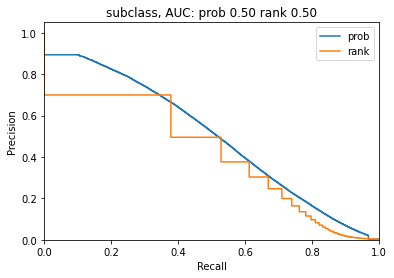

precision@1: 0.6993392787397474
recall@1: 0.3787435440940579
precision@5: 0.2465663312293284
recall@5: 0.7102554159101726
if using probability threshold at 0.11
average n: 5.001366666666667
precision: 0.26722695796482293
recall: 0.7067564470924186


In [24]:
label_to_id_map, probs = get_predicted_probs_from_FASTTEXT_other_fields(model_path, test_path, ["claims"])
truth_array = get_truth_array(TRUTH_PATH, label_to_id_map)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

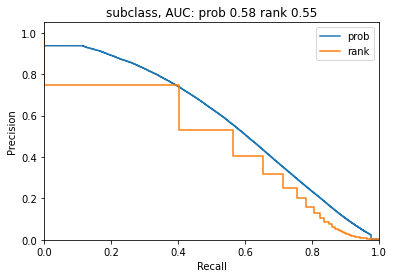

precision@1: 0.7493694519964624
recall@1: 0.4032627663887469
precision@5: 0.2510284084078801
recall@5: 0.7545786254428796
if using probability threshold at 0.085
average n: 5.0763
precision: 0.2845149682511541
recall: 0.7637535033755795


In [26]:
label_to_id_map, probs = get_predicted_probs_from_FASTTEXT_other_fields(model_path, test_path, ["title", 
                                                                                                "abstraction",
                                                                                                "claims"])
truth_array = get_truth_array(TRUTH_PATH, label_to_id_map)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")

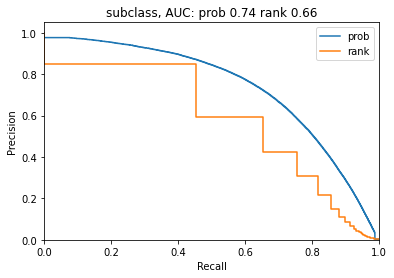

precision@1: 0.8505302165533443
recall@1: 0.45312086866087325
precision@5: 0.21571426351460848
recall@5: 0.8564100756200314
if using probability threshold at 0.025
average n: 5.3913166666666665
precision: 0.3126632640758751
recall: 0.891399763797571


In [22]:
label_to_id_map, probs = get_predicted_probs_from_FASTTEXT_other_fields(model_path, test_path, ["brief_summary"])
truth_array = get_truth_array(TRUTH_PATH, label_to_id_map)
prob_result, rank_result = get_pr_curve(truth_array, probs, "subclass")